In [28]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import fitsio
from astrometry.util.fits import fits_table, merge_tables
from glob import glob

from sklearn import mixture

# to make this notebook's output stable across runs
np.random.seed(7)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from obiwan.common import fits2pandas

In [11]:
def stack_tables(fns):
    cat=[]
    assert(len(fns) > 0)
    for fn in fns:
        assert(os.path.exists(fn))
        print('Stacking %s' % fn)
        cat.append( fits_table(fn) )
    return merge_tables(cat, columns='fillzero')

def flux2mag(nmgy):
    return -2.5 * (np.log10(nmgy) - 9)


In [15]:
def get_xy_pad(slope,pad):
    """Returns dx,dy"""
    theta= np.arctan(abs(slope))
    return pad*np.sin(theta), pad*np.cos(theta)

def y1_line(rz,pad=None):
    slope,yint= 1.15,-0.15
    if pad: 
        dx,dy= get_xy_pad(slope,pad)
        return slope*(rz+dx) + yint + dy
    else:
        return slope*rz + yint
    
def y2_line(rz,pad=None):
    slope,yint= -1.2,1.6
    if pad: 
        dx,dy= get_xy_pad(slope,pad)
        return slope*(rz-dx) + yint + dy
    else:
        return slope*rz + yint

def get_ELG_box(rz,gr, pad=None):
    """
    Args:
        rz: r-z
        gr: g-r
        pad: magnitudes of padding to expand TS box
    """
    x1,y1= rz,y1_line(rz)
    x2,y2= rz,y2_line(rz)
    x3,y3= np.array([0.3]*len(rz)),gr
    if pad:
        dx,dy= get_xy_pad(1.15,pad)
        x1,y1= x1-dx,y1+dy
        dx,dy= get_xy_pad(-1.2,pad)
        x2,y2= x2+dx,y2+dy
        x3 -= pad
    return dict(x1=x1, y1=y1,
                x2=x2, y2=y2,
                x3=x3, y3=y3)

In [55]:
def my_mixture(X):
    # Compute density via Gaussian Mixtures
    # we'll try several numbers of clusters
    n_components = np.arange(3, 16)
    gmms = [mixture.GaussianMixture(n_components=n).fit(X) 
            for n in n_components]
    BICs = [gmm.bic(X)/X.shape[0] for gmm in gmms]
    i_min = np.argmin(BICs)
    print("%d components" % n_components[i_min])
    return gmms,i_min, n_components, BICs

# DR5

In [79]:
dr5_fns= glob(os.path.join(DATA_DIR,
                'dr5.0/trimmed/decals-dr5.0-deep2-field*-trim.fits'))
dp2_fns= glob(os.path.join(DATA_DIR,
                'dr5.0/trimmed/deep2-field*-trim.fits'))                                                               
print(dr5_fns,dp2_fns)

dr5= stack_tables(dr5_fns)
dp2= stack_tables(dp2_fns)

['/Users/kaylan1/Downloads/truth/dr5.0/trimmed/decals-dr5.0-deep2-field2-trim.fits', '/Users/kaylan1/Downloads/truth/dr5.0/trimmed/decals-dr5.0-deep2-field3-trim.fits', '/Users/kaylan1/Downloads/truth/dr5.0/trimmed/decals-dr5.0-deep2-field4-trim.fits'] ['/Users/kaylan1/Downloads/truth/dr5.0/trimmed/deep2-field2-trim.fits', '/Users/kaylan1/Downloads/truth/dr5.0/trimmed/deep2-field3-trim.fits', '/Users/kaylan1/Downloads/truth/dr5.0/trimmed/deep2-field4-trim.fits']
Stacking /Users/kaylan1/Downloads/truth/dr5.0/trimmed/decals-dr5.0-deep2-field2-trim.fits
Converted brickname from |S8 to <U8
Converted type from |S4 to <U4
Converted wise_coadd_id from |S8 to <U8
Stacking /Users/kaylan1/Downloads/truth/dr5.0/trimmed/decals-dr5.0-deep2-field3-trim.fits
Converted brickname from |S8 to <U8
Converted type from |S4 to <U4
Converted wise_coadd_id from |S8 to <U8
Stacking /Users/kaylan1/Downloads/truth/dr5.0/trimmed/decals-dr5.0-deep2-field4-trim.fits
Converted brickname from |S8 to <U8
Converted typ

In [80]:
grz_gt0= ((dr5.flux_g > 0) &
          (dr5.flux_r > 0) &
          (dr5.flux_z > 0) &
          (dr5.flux_ivar_g > 0) &
          (dr5.flux_ivar_r > 0) &
          (dr5.flux_ivar_z > 0))
notCOMP= dr5.type != 'COMP'
#redshift_gt0= dp2.zhelio > 0
complDP2_buff= ((dp2.zhelio >= 0.8-0.2) & 
                (dp2.zhelio <= 1.4+0.2))

fwhm_or_rhalf= np.zeros(len(dr5))-1 # arcsec
isPSF= np.char.strip(dr5.type) == 'PSF'
isEXP= pd.Series(np.char.strip(dr5.type)).isin(['EXP','REX'])
isSIMP= np.char.strip(dr5.type) == 'SIMP'
isDEV= np.char.strip(dr5.type) == 'DEV'
# rhalf ~ fwhm/2
fwhm_or_rhalf[isPSF]= np.mean(np.array([dr5[isPSF].psfsize_g,
                                        dr5[isPSF].psfsize_r,
                                        dr5[isPSF].psfsize_z]),axis=0)/2
fwhm_or_rhalf[isSIMP]= 0.5
fwhm_or_rhalf[isEXP]= dr5[isEXP].shapeexp_r
fwhm_or_rhalf[isDEV]= dr5[isDEV].shapedev_r
dr5.set('fwhm_or_rhalf',fwhm_or_rhalf)

print(len(dr5),len(dp2))
print(len(dr5[grz_gt0]), len(dr5[~notCOMP]))
print(len(dr5[fwhm_or_rhalf < 5]),len(dr5[complDP2_buff]))

print(set(dr5.type))
print(pd.Series(dr5.type).value_counts()/len(dr5))

28300 28300
27707 78
28283 23211
{'COMP', 'DEV', 'REX', 'EXP', 'PSF'}
REX     0.506325
PSF     0.324912
EXP     0.138834
DEV     0.027173
COMP    0.002756
dtype: float64


In [81]:
keep= ((grz_gt0) & 
       (notCOMP) & 
       (fwhm_or_rhalf < 5) & 
       (complDP2_buff)) 
dr5.cut(keep)
dp2.cut(keep)
len(dr5)


d= {}
for i,b in zip([1,2,4],'grz'):
    d[b]= flux2mag(dr5.get('flux_'+b)/dr5.get('mw_transmission_'+b))
    #d[b+'_ivar']= flux2mag(dr5.get('decam_flux_ivar')[:,i]/dr5.get('decam_mw_transmission')[:,i])  
d['redshift']= dp2.get('zhelio')
d['fwhm_or_rhalf']= dr5.fwhm_or_rhalf
d['type']= dr5.get('type')
df= pd.DataFrame(d)

df['g-r']= df['g'] - df['r']
df['r-z']= df['r'] - df['z']

inBox= ((df['g-r'] <= y1_line(df['r-z'],pad=0.5)) &
        (df['g-r'] <= y2_line(df['r-z'],pad=0.5)) & 
        (df['r-z'] >= 0.3 - 0.5))

(-0.6, 2.2)

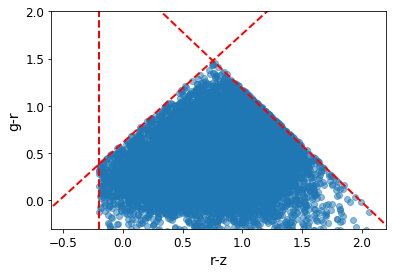

In [82]:
fig,ax=plt.subplots()
ax.scatter(df.loc[inBox,'r-z'], df.loc[inBox,'g-r'],alpha=0.5)
ax.plot(pad['x1'],pad['y1'],c=color,ls='--',lw=2)
ax.plot(pad['x2'],pad['y2'],c=color,ls='--',lw=2)
ax.plot(pad['x3'],pad['y3'],c=color,ls='--',lw=2)
ax.set_xlabel('r-z')
ax.set_ylabel('g-r')
ax.set_ylim(-0.3,2)
ax.set_xlim(-0.6,2.2)

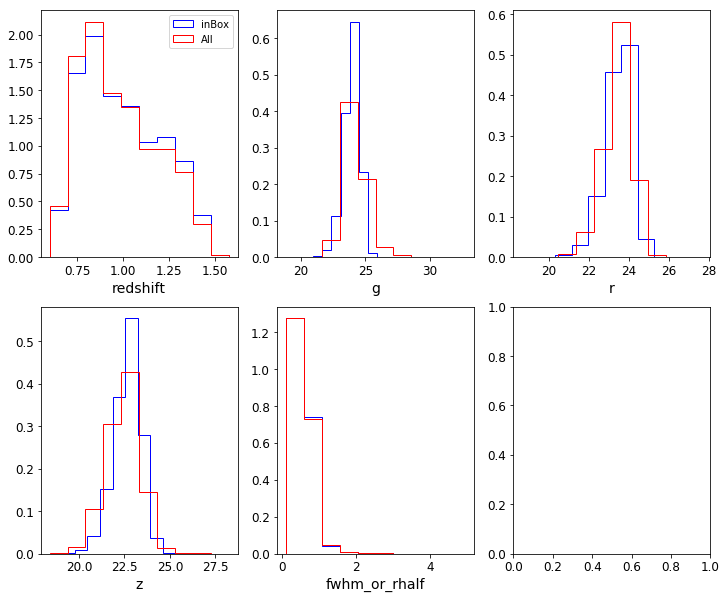

In [83]:
attrs= ['redshift','g','r','z','fwhm_or_rhalf']

fig,ax= plt.subplots(2,3,figsize=(12,10))
i=-1
for row in range(2):
    for col in range(3):
        i+=1
        if i >= len(cols):
            continue
        _=ax[row,col].hist(df.loc[inBox,attrs[i]],histtype='step',normed=True,
                           color='b',label='inBox')
        _=ax[row,col].hist(df[attrs[i]],histtype='step',normed=True,
                           color='r',label='All')
        ax[row,col].set_xlabel(attrs[i])
        if i == 0:
            ax[row,col].legend()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e99a908>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11d30acf8>]], dtype=object)

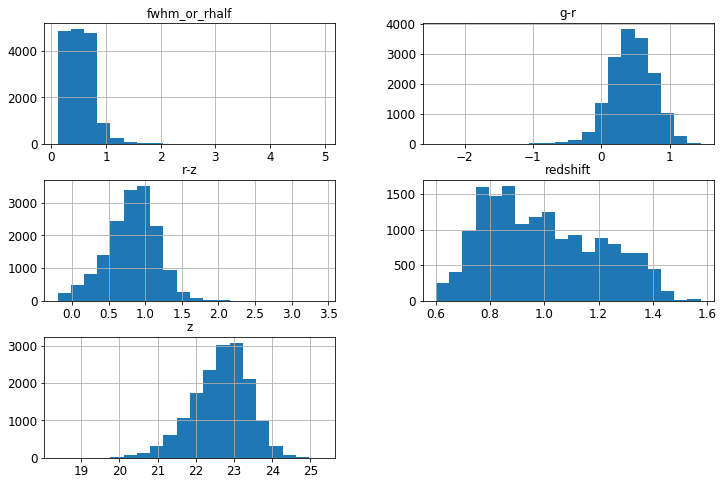

In [84]:
fit_cols= ['fwhm_or_rhalf', 'g-r', 'r-z','z','redshift']
df_new= df.loc[inBox,fit_cols]
df_new.hist(bins=20,figsize=(12,8))

15 components


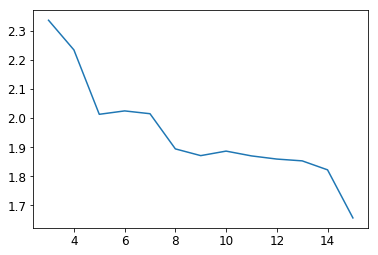

In [85]:
X= df_new.values
gmms,i_min, n_comp, BICs= my_mixture(X)
plt.plot(n_comp,BICs)

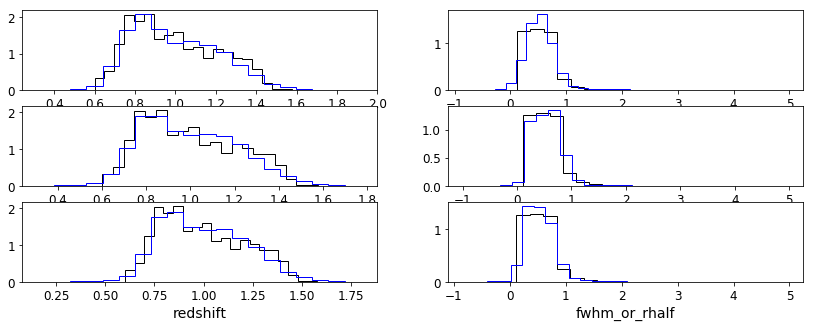

In [86]:
fig,ax= plt.subplots(3,2,figsize=(14,5))

for row,n in enumerate([6,9,12]):
    i= np.where(n_comp == n)[0][0]
    Xpred,Ypred= gmms[i].sample(10000)
    _,bins,_= ax[row,0].hist(df_new['redshift'],bins=20,histtype='step',color='k',normed=True)
    _=ax[row,0].hist(Xpred[:,-1],bins=20,histtype='step',color='b',normed=True)
    #ax[1].set_xlabel('redshift')

    _,bins,_= ax[row,1].hist(df_new['fwhm_or_rhalf'],bins=20,histtype='step',color='k',normed=True)
    _=ax[row,1].hist(Xpred[:,0],bins=20,histtype='step',color='b',normed=True)
    #ax[2].set_xlabel('fwhm_or_rhalf')

ax[2,0].set_xlabel('redshift')
ax[2,1].set_xlabel('fwhm_or_rhalf')

In [87]:
gmm= gmms[np.where(n_comp == 9)[0][0]]
logprob= gmm.score_samples(X)
responsibilities = gmm.predict_proba(X)

Xpred,Ypred= gmm.sample(10000)
d={}
for i,col in enumerate(fit_cols):
    d[col]= Xpred[:,i]
df_pred= pd.DataFrame(d)

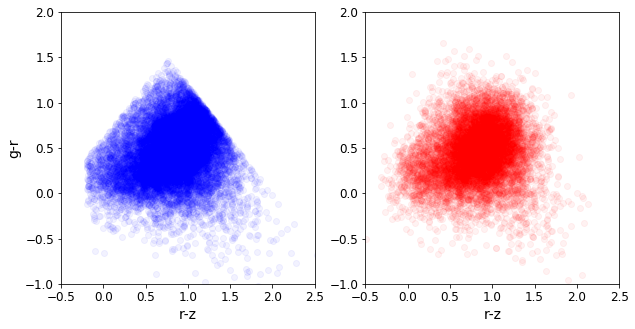

In [88]:
fig,ax= plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(df_new['r-z'],df_new['g-r'],color='b',alpha=0.05)
ax[1].scatter(df_pred['r-z'],df_pred['g-r'],color='r',alpha=0.05)
for i in range(2):
    ax[i].set_xlabel('r-z')
    ax[i].set_xlim(-0.5,2.5)
    ax[i].set_ylim(-1,2)
ax[0].set_ylabel('g-r')

0.113249689341


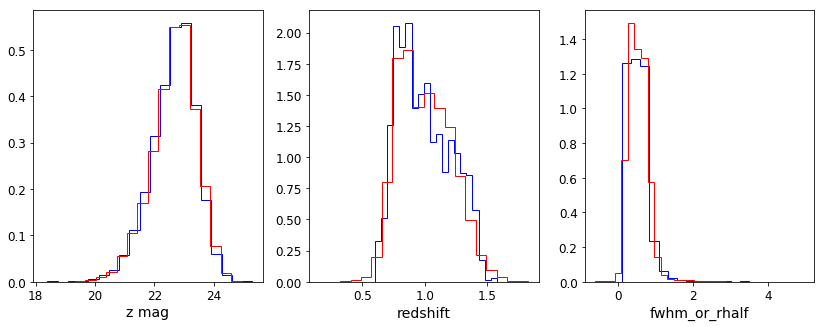

In [89]:
fig,ax= plt.subplots(1,3,figsize=(14,5))

_,bins,_= ax[0].hist(df_new['z'],bins=20,histtype='step',color='b',normed=True)
_=ax[0].hist(df_pred['z'],bins=20,histtype='step',color='r',normed=True)
ax[0].set_xlabel('z mag')

_,bins,_= ax[1].hist(df_new['redshift'],bins=20,histtype='step',color='b',normed=True)
_=ax[1].hist(df_pred['redshift'],bins=20,histtype='step',color='r',normed=True)
ax[1].set_xlabel('redshift')

_,bins,_= ax[2].hist(df_new['fwhm_or_rhalf'],bins=20,histtype='step',color='b',normed=True)
_=ax[2].hist(df_pred['fwhm_or_rhalf'],bins=20,histtype='step',color='r',normed=True)
ax[2].set_xlabel('fwhm_or_rhalf')

print(df_new['fwhm_or_rhalf'].min())

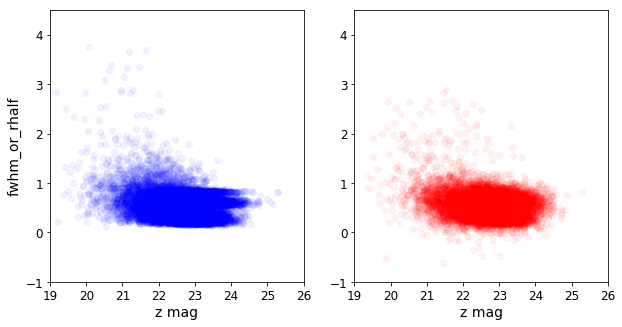

In [90]:
fig,ax= plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(df_new['z'],df_new['fwhm_or_rhalf'],color='b',alpha=0.05)
ax[1].scatter(df_pred['z'],df_pred['fwhm_or_rhalf'],color='r',alpha=0.05)
for i in range(2):
    ax[i].set_xlabel('z mag')
ax[0].set_ylabel('fwhm_or_rhalf')
for i in range(2):
    ax[i].set_xlim(19,26)
    ax[i].set_ylim(-1,4.5)

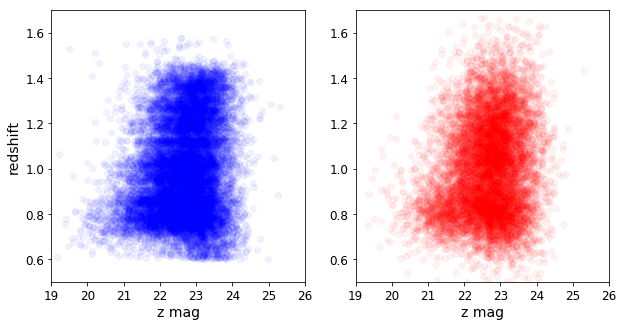

In [91]:
fig,ax= plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(df_new['z'],df_new['redshift'],color='b',alpha=0.05)
ax[1].scatter(df_pred['z'],df_pred['redshift'],color='r',alpha=0.05)
for i in range(2):
    ax[i].set_xlabel('z mag')
ax[0].set_ylabel('redshift')
for i in range(2):
    ax[i].set_xlim(19,26)
    ax[i].set_ylim(0.5,1.7)

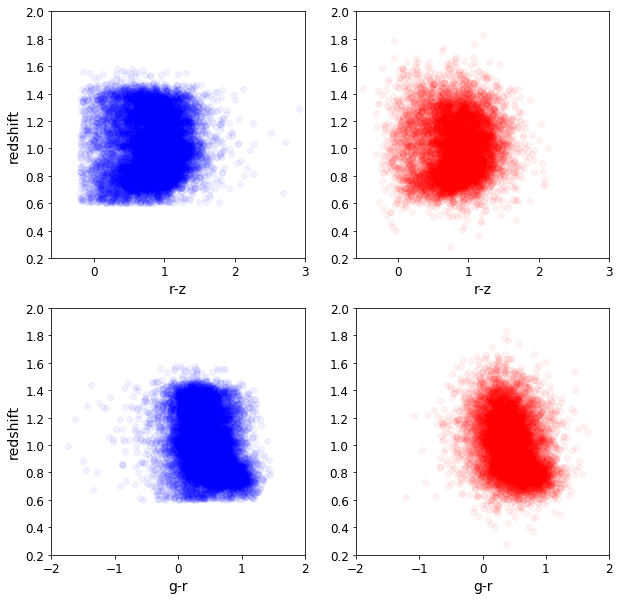

In [92]:
fig,ax= plt.subplots(2,2,figsize=(10,10))
ax[0,0].scatter(df_new['r-z'],df_new['redshift'],color='b',alpha=0.05)
ax[0,1].scatter(df_pred['r-z'],df_pred['redshift'],color='r',alpha=0.05)
for i in range(2):
    ax[0,i].set_xlabel('r-z')
    ax[0,i].set_xlim(-0.6,3)
    ax[0,i].set_ylim(0.2,2)
    
ax[1,0].scatter(df_new['g-r'],df_new['redshift'],color='b',alpha=0.05)
ax[1,1].scatter(df_pred['g-r'],df_pred['redshift'],color='r',alpha=0.05)
for i in range(2):
    ax[1,i].set_xlabel('g-r')
    ax[1,i].set_xlim(-2,2)
    ax[1,i].set_ylim(0.2,2)
    
for i in range(2):
    ax[i,0].set_ylabel('redshift')

count    15919.000000
mean         0.537243
std          0.271235
min          0.113250
25%          0.320844
50%          0.536520
75%          0.678899
max          4.954905
Name: fwhm_or_rhalf, dtype: float64

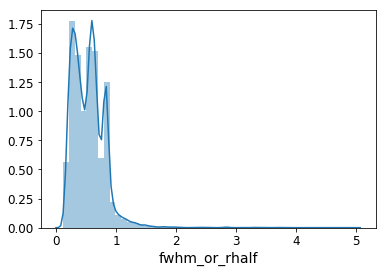

In [96]:
sns.distplot(df_new['fwhm_or_rhalf'])
df_new['fwhm_or_rhalf'].describe()

In [97]:
print(fit_cols)

['fwhm_or_rhalf', 'g-r', 'r-z', 'z', 'redshift']


## Resample until have 10k within redshift and rhalf limits

In [99]:
red_lim= (0.6,1.6) # DESI
rhalf_lim= (0.262/2,2.) # Camera, Data

Xpred,Ypred= gmm.sample(10000)
outLimit= ((Xpred[:,0] < rhalf_lim[0]) |
               (Xpred[:,0] > rhalf_lim[1]) |
               (Xpred[:,-1] < red_lim[0]) |
               (Xpred[:,-1] > red_lim[1]))
i=0
num= len(Ypred[outLimit])
while num > 0:
    i+=1
    if i > 10:
        raise ValueError
    print(num)
    Xpred[outLimit,:],Ypred[outLimit]= gmm.sample(num)
    outLimit= ((Xpred[:,0] < rhalf_lim[0]) |
               (Xpred[:,0] > rhalf_lim[1]) |
               (Xpred[:,-1] < red_lim[0]) |
               (Xpred[:,-1] > red_lim[1]))
    num= len(Ypred[outLimit])

313
11


In [101]:
d={}
for i,col in enumerate(fit_cols):
    d[col]= Xpred[:,i]
df_fin= pd.DataFrame(d)

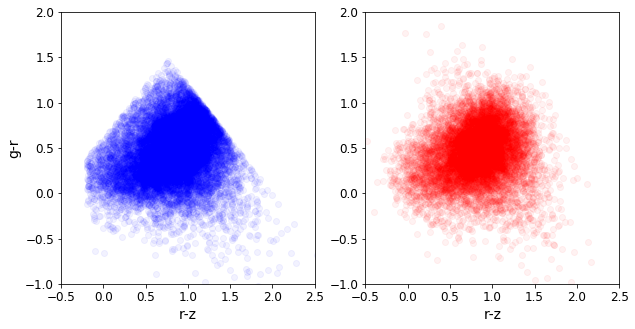

In [103]:
fig,ax= plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(df_new['r-z'],df_new['g-r'],color='b',alpha=0.05)
ax[1].scatter(df_fin['r-z'],df_fin['g-r'],color='r',alpha=0.05)
for i in range(2):
    ax[i].set_xlabel('r-z')
    ax[i].set_xlim(-0.5,2.5)
    ax[i].set_ylim(-1,2)
ax[0].set_ylabel('g-r')

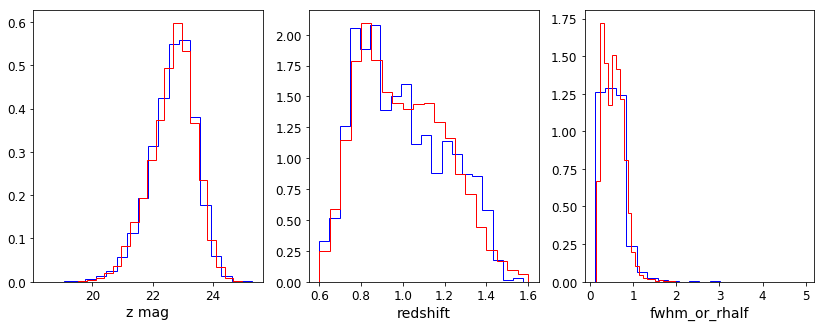

In [104]:
fig,ax= plt.subplots(1,3,figsize=(14,5))

_,bins,_= ax[0].hist(df_new['z'],bins=20,histtype='step',color='b',normed=True)
_=ax[0].hist(df_fin['z'],bins=20,histtype='step',color='r',normed=True)
ax[0].set_xlabel('z mag')

_,bins,_= ax[1].hist(df_new['redshift'],bins=20,histtype='step',color='b',normed=True)
_=ax[1].hist(df_fin['redshift'],bins=20,histtype='step',color='r',normed=True)
ax[1].set_xlabel('redshift')

_,bins,_= ax[2].hist(df_new['fwhm_or_rhalf'],bins=20,histtype='step',color='b',normed=True)
_=ax[2].hist(df_fin['fwhm_or_rhalf'],bins=20,histtype='step',color='r',normed=True)
ax[2].set_xlabel('fwhm_or_rhalf')

### Save the sample

In [108]:
np.arange(100).dtype

dtype('int64')

In [110]:
df_fin.columns
a=fits_table()
a.set('id',np.arange(len(df_fin)))
a.set('rhalf',df_fin['fwhm_or_rhalf'].values)
a.set('redshift',df_fin['redshift'].values)
a.set('z',df_fin['z'].values)
a.set('r',df_fin['r-z'].values + a.z)
a.set('g',df_fin['g-r'].values + a.r)
a.writeto('desi_5d_sample.fits')

# MoG to n(z) DESI

In [111]:
# TODO replace with 100,000 random draws from n(z)
z_10k= fits_table(os.path.join(DATA_DIR,'sanchez_kirkby_z_rand10k.fits'))

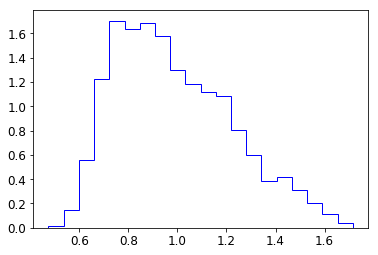

In [112]:
_=plt.hist(z_10k.z_cosmo,bins=20,histtype='step',color='b',normed=True)


4 components


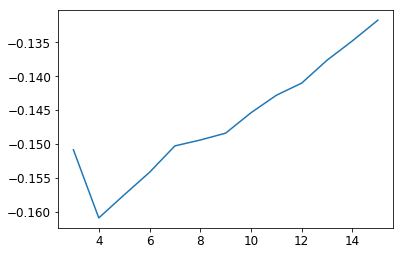

In [115]:
X= z_10k.z_cosmo.reshape(-1,1)
gmms,i_min, n_comp, BICs= my_mixture(X)
plt.plot(n_comp,BICs)

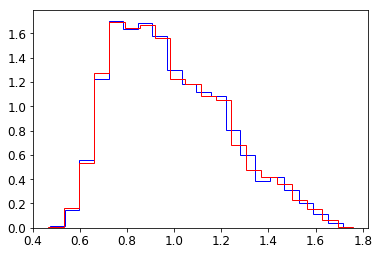

In [126]:
gmm= gmms[12]
z_pred,pdf_pred= gmm.sample(100000)
_=plt.hist(z_10k.z_cosmo,bins=20,histtype='step',color='b',normed=True)
_=plt.hist(z_pred,bins=20,histtype='step',color='r',normed=True)

## Draw from n(z), match to 10k dr3-deep2 sample, plot redshift distribution of new dr3-deep2-nz sample

In [127]:
from scipy import spatial
tree = spatial.KDTree(df_fin['redshift'].values.reshape(-1,1))

In [131]:
nz_z,nz_pdf= gmm.sample(100000)
_,ind= tree.query(nz_z)
randoms= df_fin.loc[ind,:]
len(df_fin),len(nz_z),len(randoms)

(10000, 100000, 100000)

In [136]:
# Randoms table 
a=fits_table()
a.set('id',np.arange(len(randoms)))
a.set('rhalf',randoms['fwhm_or_rhalf'].values)
a.set('redshift',randoms['redshift'].values)
a.set('z',randoms['z'].values)
a.set('r',randoms['r-z'].values + a.z)
a.set('g',randoms['g-r'].values + a.r)
a.writeto('randoms_nz_dr3deep2.fits')

In [138]:
samp= fits_table('desi_5d_sample.fits')
# ID table with randoms ID and ID in 10k sample
a=fits_table()
a.set('id_randoms',np.arange(len(randoms)))
a.set('id_5dsample',samp[ind].id)
a.writeto('id_randoms_5dsample.fits')

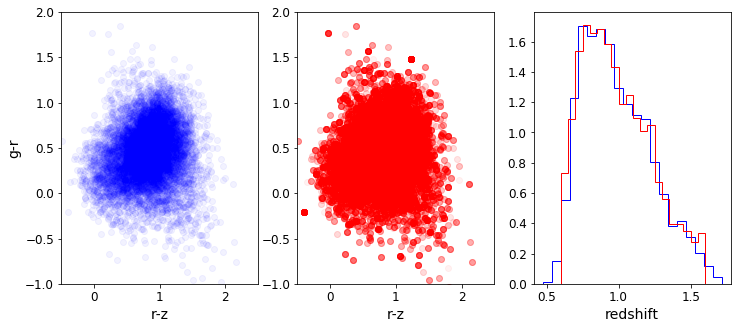

In [139]:
fig,ax= plt.subplots(1,3,figsize=(12,5))
ax[0].scatter(df_fin['r-z'],df_fin['g-r'],color='b',alpha=0.05)
ax[1].scatter(randoms['r-z'],randoms['g-r'],color='r',alpha=0.05)
_=ax[2].hist(z_10k.z_cosmo,bins=20,histtype='step',color='b',normed=True)
_=ax[2].hist(randoms['redshift'],bins=20,histtype='step',color='r',normed=True)
for i in range(2):
    ax[i].set_xlabel('r-z')
    ax[i].set_xlim(-0.5,2.5)
    ax[i].set_ylim(-1,2)
ax[0].set_ylabel('g-r')
ax[2].set_xlabel('redshift')

# eBOSS

In [17]:
DATA_DIR = os.path.join(os.environ['HOME'],'Downloads',
                        'truth')
dr3_fns= glob(os.path.join(DATA_DIR,
                'dr3.1/trimmed/decals-dr3.1-deep2-field*-trim.fits'))
dp2_fns= glob(os.path.join(DATA_DIR,
                'dr3.1/trimmed/deep2-field*-trim.fits'))                                                                                                                             
print(dr3_fns,dp2_fns)

dr3= stack_tables(dr3_fns)
dp2= stack_tables(dp2_fns)


['/Users/kaylan1/Downloads/truth/dr3.1/trimmed/decals-dr3.1-deep2-field2-trim.fits', '/Users/kaylan1/Downloads/truth/dr3.1/trimmed/decals-dr3.1-deep2-field3-trim.fits', '/Users/kaylan1/Downloads/truth/dr3.1/trimmed/decals-dr3.1-deep2-field4-trim.fits'] ['/Users/kaylan1/Downloads/truth/dr3.1/trimmed/deep2-field2-trim.fits', '/Users/kaylan1/Downloads/truth/dr3.1/trimmed/deep2-field3-trim.fits', '/Users/kaylan1/Downloads/truth/dr3.1/trimmed/deep2-field4-trim.fits']
Stacking /Users/kaylan1/Downloads/truth/dr3.1/trimmed/decals-dr3.1-deep2-field2-trim.fits
Converted brickname from |S8 to <U8
Converted type from |S4 to <U4
Stacking /Users/kaylan1/Downloads/truth/dr3.1/trimmed/decals-dr3.1-deep2-field3-trim.fits
Converted brickname from |S8 to <U8
Converted type from |S4 to <U4
Stacking /Users/kaylan1/Downloads/truth/dr3.1/trimmed/decals-dr3.1-deep2-field4-trim.fits
Converted brickname from |S8 to <U8
Converted type from |S4 to <U4
Stacking /Users/kaylan1/Downloads/truth/dr3.1/trimmed/deep2-fi

In [18]:
grz_gt0= (np.all(dr3.decam_flux[:,[1,2,4]] > 0,axis=1) &
          np.all(dr3.decam_flux_ivar[:,[1,2,4]] > 0,axis=1))
notCOMP= dr3.type != 'COMP'
#redshift_gt0= dp2.zhelio > 0
complDP2_buff= ((dp2.zhelio >= 0.8-0.2) & 
                (dp2.zhelio <= 1.4+0.2))

fwhm_or_rhalf= np.zeros(len(dr3))-1 # arcsec
isPSF= np.char.strip(dr3.type) == 'PSF'
isEXP= np.char.strip(dr3.type) == 'EXP'
isSIMP= np.char.strip(dr3.type) == 'SIMP'
isDEV= np.char.strip(dr3.type) == 'DEV'
fwhm_or_rhalf[isPSF]= np.mean(dr3[isPSF].decam_psfsize[:,[1,2,4]],axis=1)
fwhm_or_rhalf[isSIMP]= 0.5
fwhm_or_rhalf[isEXP]= dr3[isEXP].shapeexp_r
fwhm_or_rhalf[isDEV]= dr3[isDEV].shapedev_r
dr3.set('fwhm_or_rhalf',fwhm_or_rhalf)

print(len(dr3),len(dp2))
print(len(dr3[grz_gt0]), len(dr3[~notCOMP]))
print(len(dr3[fwhm_or_rhalf < 5]),len(dr3[complDP2_buff]))

print(set(dr3.type))
print(pd.Series(dr3.type).value_counts()/len(dr3))



28284 28284
27433 76
28265 23212
{'COMP', 'DEV', 'SIMP', 'EXP', 'PSF'}
PSF     0.440815
SIMP    0.335349
EXP     0.184557
DEV     0.036593
COMP    0.002687
dtype: float64


In [19]:
keep= ((grz_gt0) & 
       (notCOMP) & 
       (fwhm_or_rhalf < 5) & 
       (complDP2_buff)) 
dr3.cut(keep)
dp2.cut(keep)
len(dr3)


d= {}
for i,b in zip([1,2,4],'grz'):
    d[b]= flux2mag(dr3.get('decam_flux')[:,i]/dr3.get('decam_mw_transmission')[:,i])
    #d[b+'_ivar']= flux2mag(dr3.get('decam_flux_ivar')[:,i]/dr3.get('decam_mw_transmission')[:,i])  
d['redshift']= dp2.get('zhelio')
d['fwhm_or_rhalf']= dr3.fwhm_or_rhalf
d['type']= dr3.get('type')
df= pd.DataFrame(d)

df['g-r']= df['g'] - df['r']
df['r-z']= df['r'] - df['z']

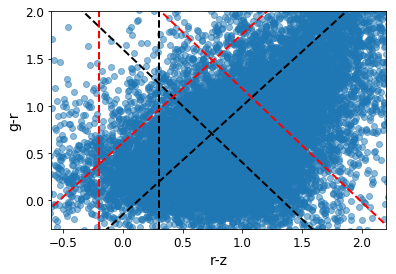

In [21]:
fig,ax=plt.subplots()
ax.scatter(df['r-z'],df['g-r'],alpha=0.5)
ax.set_xlabel('r-z')
ax.set_ylabel('g-r')
ax.set_ylim(-0.3,2)
ax.set_xlim(-0.6,2.2)

rz= np.linspace(ax.get_xlim()[0],ax.get_xlim()[1])
gr= np.linspace(ax.get_ylim()[0],ax.get_ylim()[1])
nopad= get_ELG_box(rz,gr)
pad= get_ELG_box(rz,gr,pad=0.5)
for d,color in zip([nopad,pad],['k','r']):
    ax.plot(d['x1'],d['y1'],c=color,ls='--',lw=2)
    ax.plot(d['x2'],d['y2'],c=color,ls='--',lw=2)
    ax.plot(d['x3'],d['y3'],c=color,ls='--',lw=2)


(-0.6, 2.2)

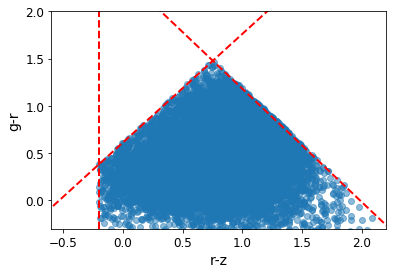

In [22]:
inBox= ((df['g-r'] <= y1_line(df['r-z'],pad=0.5)) &
        (df['g-r'] <= y2_line(df['r-z'],pad=0.5)) & 
        (df['r-z'] >= 0.3 - 0.5))

fig,ax=plt.subplots()
ax.scatter(df.loc[inBox,'r-z'], df.loc[inBox,'g-r'],alpha=0.5)
ax.plot(pad['x1'],pad['y1'],c=color,ls='--',lw=2)
ax.plot(pad['x2'],pad['y2'],c=color,ls='--',lw=2)
ax.plot(pad['x3'],pad['y3'],c=color,ls='--',lw=2)
ax.set_xlabel('r-z')
ax.set_ylabel('g-r')
ax.set_ylim(-0.3,2)
ax.set_xlim(-0.6,2.2)



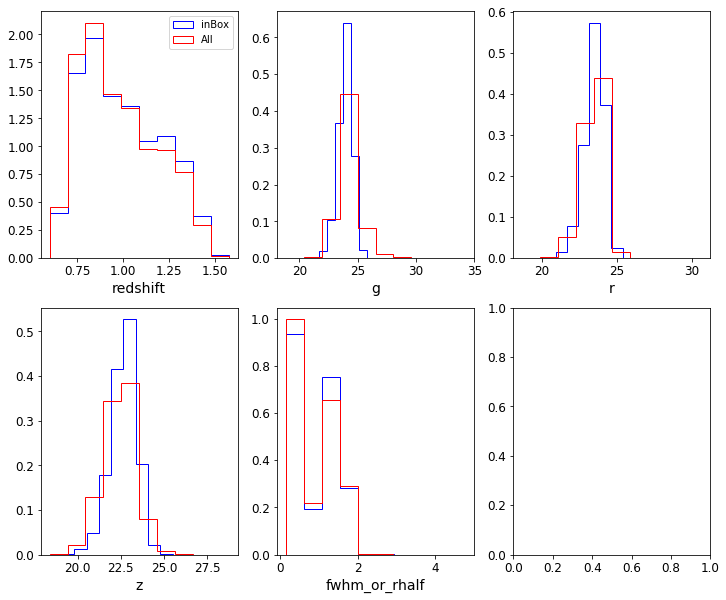

In [24]:
attrs= ['redshift','g','r','z','fwhm_or_rhalf']

fig,ax= plt.subplots(2,3,figsize=(12,10))
i=-1
for row in range(2):
    for col in range(3):
        i+=1
        if i >= len(attrs):
            continue
        _=ax[row,col].hist(df.loc[inBox,attrs[i]],histtype='step',normed=True,
                           color='b',label='inBox')
        _=ax[row,col].hist(df[attrs[i]],histtype='step',normed=True,
                           color='r',label='All')
        ax[row,col].set_xlabel(attrs[i])
        if i == 0:
            ax[row,col].legend()



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117116ac8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1152b2eb8>]], dtype=object)

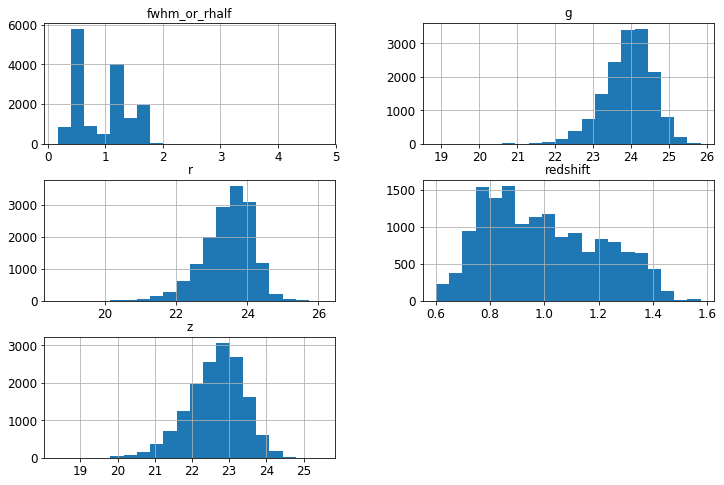

In [25]:
cols=['fwhm_or_rhalf', 'g', 'r', 'redshift', 'z']
df.loc[inBox,cols].hist(bins=20,figsize=(12,8))



14 components


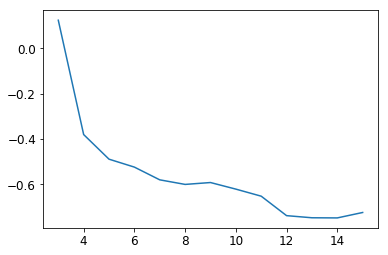

In [30]:
fit_cols= ['fwhm_or_rhalf', 'g-r', 'r-z','z','redshift']
df_new= df.loc[inBox,fit_cols]

X= df_new.values
gmm, n_comp, BICs= my_mixture(X)
logprob= gmm.score_samples(X)
responsibilities = gmm.predict_proba(X)

plt.plot(n_comp,BICs)



In [31]:
Xpred,Ypred= gmm.sample(10000)
d={}
for i,col in enumerate(fit_cols):
    d[col]= Xpred[:,i]
df_pred= pd.DataFrame(d)





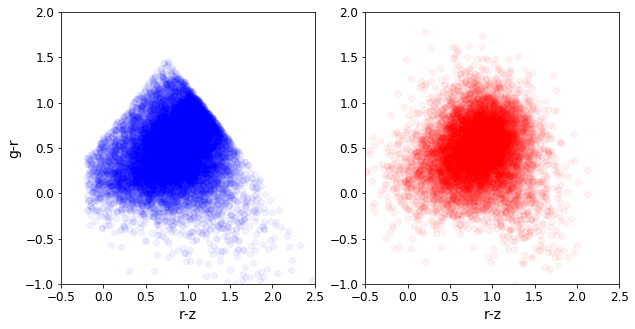

In [32]:
fig,ax= plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(df_new['r-z'],df_new['g-r'],color='b',alpha=0.05)
ax[1].scatter(df_pred['r-z'],df_pred['g-r'],color='r',alpha=0.05)
for i in range(2):
    ax[i].set_xlabel('r-z')
    ax[i].set_xlim(-0.5,2.5)
    ax[i].set_ylim(-1,2)
ax[0].set_ylabel('g-r')



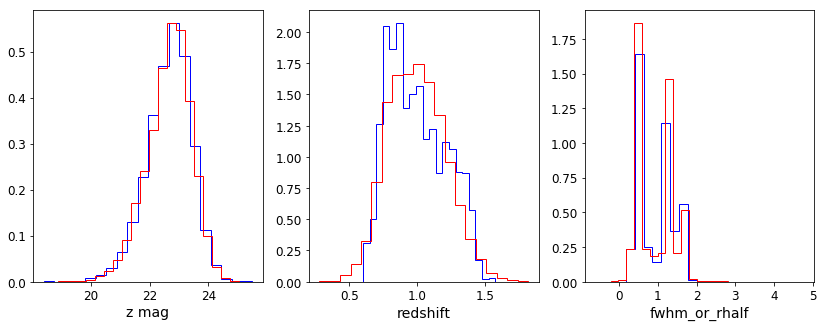

In [34]:
fig,ax= plt.subplots(1,3,figsize=(14,5))

_,bins,_= ax[0].hist(df_new['z'],bins=20,histtype='step',color='b',normed=True)
_=ax[0].hist(df_pred['z'],bins=20,histtype='step',color='r',normed=True)
ax[0].set_xlabel('z mag')

_,bins,_= ax[1].hist(df_new['redshift'],bins=20,histtype='step',color='b',normed=True)
_=ax[1].hist(df_pred['redshift'],bins=20,histtype='step',color='r',normed=True)
ax[1].set_xlabel('redshift')

_,bins,_= ax[2].hist(df_new['fwhm_or_rhalf'],bins=20,histtype='step',color='b',normed=True)
_=ax[2].hist(df_pred['fwhm_or_rhalf'],bins=20,histtype='step',color='r',normed=True)
ax[2].set_xlabel('fwhm_or_rhalf')



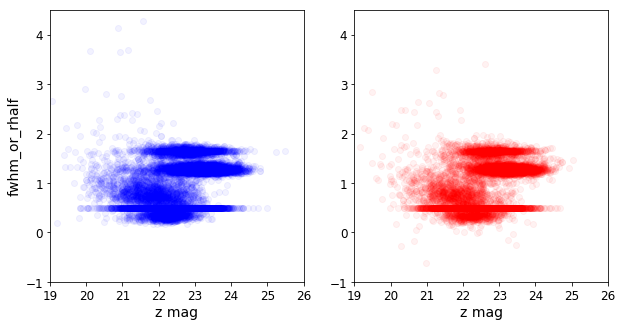

In [35]:
fig,ax= plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(df_new['z'],df_new['fwhm_or_rhalf'],color='b',alpha=0.05)
ax[1].scatter(df_pred['z'],df_pred['fwhm_or_rhalf'],color='r',alpha=0.05)
for i in range(2):
    ax[i].set_xlabel('z mag')
ax[0].set_ylabel('fwhm_or_rhalf')
for i in range(2):
    ax[i].set_xlim(19,26)
    ax[i].set_ylim(-1,4.5)



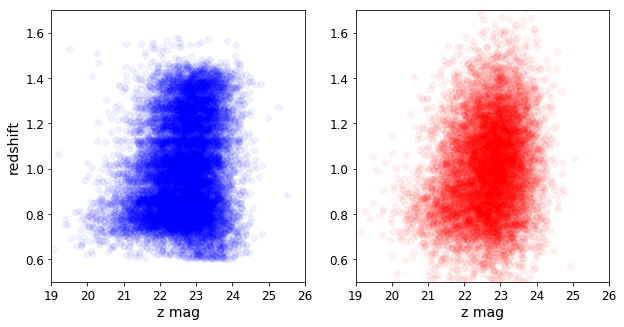

In [36]:
fig,ax= plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(df_new['z'],df_new['redshift'],color='b',alpha=0.05)
ax[1].scatter(df_pred['z'],df_pred['redshift'],color='r',alpha=0.05)
for i in range(2):
    ax[i].set_xlabel('z mag')
ax[0].set_ylabel('redshift')
for i in range(2):
    ax[i].set_xlim(19,26)
    ax[i].set_ylim(0.5,1.7)



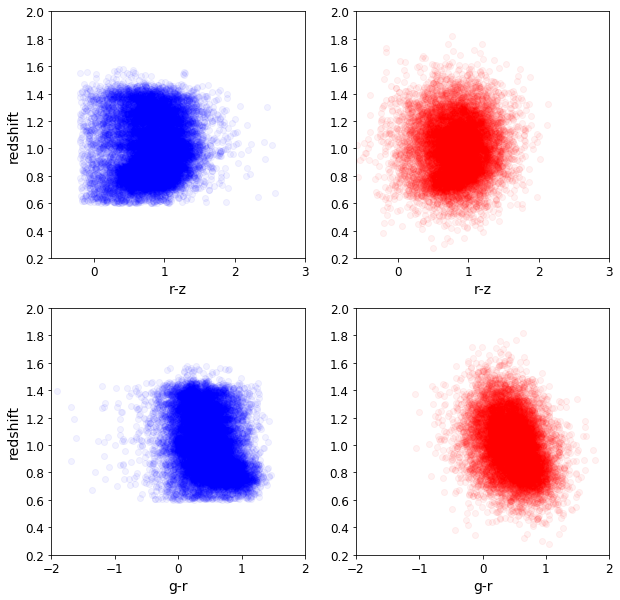

In [37]:
fig,ax= plt.subplots(2,2,figsize=(10,10))
ax[0,0].scatter(df_new['r-z'],df_new['redshift'],color='b',alpha=0.05)
ax[0,1].scatter(df_pred['r-z'],df_pred['redshift'],color='r',alpha=0.05)
for i in range(2):
    ax[0,i].set_xlabel('r-z')
    ax[0,i].set_xlim(-0.6,3)
    ax[0,i].set_ylim(0.2,2)
    
ax[1,0].scatter(df_new['g-r'],df_new['redshift'],color='b',alpha=0.05)
ax[1,1].scatter(df_pred['g-r'],df_pred['redshift'],color='r',alpha=0.05)
for i in range(2):
    ax[1,i].set_xlabel('g-r')
    ax[1,i].set_xlim(-2,2)
    ax[1,i].set_ylim(0.2,2)
    
for i in range(2):
    ax[i,0].set_ylabel('redshift')